# Comparative Performance Analysis of GA, IGA, and IGA-SOM on GYTS-4 Dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

# Genetic Algorithm related libraries
from deap import base, creator, tools, algorithms
import random

# Self-Organizing Map
from minisom import MiniSom

In [7]:
# Load Dataset
data = pd.read_csv('dataset/GYTS4.csv')

# Menampilkan lima data teratas dari dataset
print(data.head())

                      State/UT   Area  Ever tobacco users (%)  \
0                        India  Total                    18.1   
1                        India  Urban                    13.5   
2                        India  Rural                    19.5   
3  Andaman and Nicobar Islands  Total                    21.5   
4  Andaman and Nicobar Islands  Urban                    13.3   

   Current tobacco users (%)  Ever tobacco smokers (%)  \
0                        8.5                      11.0   
1                        5.5                       8.1   
2                        9.4                      11.8   
3                        4.4                       8.8   
4                        3.4                       6.5   

   Current tobacco smokers (%)  Ever cigarette users (%)  \
0                          7.3                       4.6   
1                          4.5                       4.1   
2                          8.1                       4.7   
3                   

In [8]:
# --- Step 1: Data Preprocessing ---

# Drop missing values (if any)
data = data.dropna()

# Select only numerical features for scaling
numerical_features = data.select_dtypes(include=np.number).columns
data_numerical = data[numerical_features]

# Feature Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_numerical)

# Dimensionality Reduction using scaled numerical features
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

In [9]:
# --- Step 2: Initial Clustering with KMeans++ ---

# (Optional, baseline, but minimal discussion later)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)

kmeans_silhouette = silhouette_score(data_pca, kmeans_labels)
kmeans_dbi = davies_bouldin_score(data_pca, kmeans_labels)


In [10]:
# --- Step 3: Clustering with Genetic Algorithm (GA) ---

# Setup GA for clustering (basic version)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define individual and population
IND_SIZE = 6  # Assume clustering into 3 clusters (2D PCA space x 3 centroids)

# Helper functions for GA
def generate_individual():
    # Use KMeans++ to initialize centroids
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42).fit(data_pca)
    initial_centroids = kmeans.cluster_centers_
    return initial_centroids.flatten().tolist()  # Flatten and convert to list

def evaluate(individual):
    centroids = np.array(individual).reshape((3, 2))
    labels = np.argmin(np.linalg.norm(data_pca[:, np.newaxis] - centroids, axis=2), axis=1)
    return silhouette_score(data_pca, labels),

# Toolbox setup
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# GA parameters
population = toolbox.population(n=50)
NGEN = 40
CXPB, MUTPB = 0.5, 0.2

# Run GA
hof = tools.HallOfFame(1)
population, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                       halloffame=hof, verbose=True)

best_centroids = np.array(hof[0]).reshape((3, 2))

ga_labels = np.argmin(np.linalg.norm(data_pca[:, np.newaxis] - best_centroids, axis=2), axis=1)

ga_silhouette = silhouette_score(data_pca, ga_labels)
ga_dbi = davies_bouldin_score(data_pca, ga_labels)

gen	nevals
0  	50    
1  	20    
2  	30    
3  	22    
4  	31    
5  	28    
6  	31    
7  	36    
8  	32    
9  	26    
10 	43    
11 	33    
12 	33    
13 	32    
14 	37    
15 	32    
16 	27    
17 	31    
18 	32    
19 	27    
20 	39    
21 	23    
22 	28    
23 	24    
24 	33    
25 	36    
26 	26    
27 	25    
28 	32    
29 	32    
30 	30    
31 	23    
32 	32    
33 	29    
34 	33    
35 	32    
36 	25    
37 	26    
38 	32    
39 	26    
40 	31    


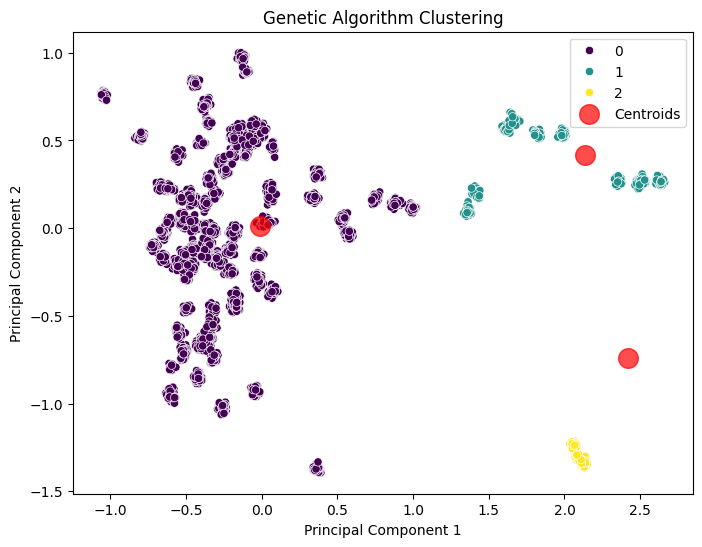

GA Silhouette Score: 0.6725738479919414
GA Davies-Bouldin Index: 0.3838189014906455


In [11]:
# prompt: create a cluster visualization for the genetic algorithm above

# Visualize GA Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=ga_labels, palette='viridis', legend='full')
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], c='red', s=200, alpha=0.7, label='Centroids')
plt.title('Genetic Algorithm Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

print(f"GA Silhouette Score: {ga_silhouette}")
print(f"GA Davies-Bouldin Index: {ga_dbi}")

In [ ]:
# --- Step 4: Clustering with Improved Genetic Algorithm (IGA) ---

# IGA: Adaptive mutation, elitism

# Updated mutate function (adaptive)
def adaptive_mutate(individual, gen, max_gen):
    sigma = 0.5 * (1 - gen/max_gen)
    tools.mutGaussian(individual, mu=0, sigma=sigma, indpb=0.2)
    return individual,

hof_iga = tools.HallOfFame(1)
population_iga = toolbox.population(n=50)

for gen in range(NGEN):
    offspring = algorithms.varAnd(population_iga, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = []
    for ind in offspring:
        # Evaluate individual

        # The following loop ensures the individual has more than one unique label
        # before calculating the fitness
        while True:
            fit = toolbox.evaluate(ind)
            centroids = np.array(ind).reshape((3, 2))
            labels = np.argmin(np.linalg.norm(data_pca[:, np.newaxis] - centroids, axis=2), axis=1)
            if len(np.unique(labels)) > 1:  # Break the loop if there is more than one cluster
                break
            else:
                ind = toolbox.individual()  # Generate a new individual if only one cluster

        fits.append(fit)  # Store the fitness

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population_iga = toolbox.select(offspring, k=len(population_iga))

    # Adaptive mutation
    for ind in population_iga:
        adaptive_mutate(ind, gen, NGEN)

    hof_iga.update(population_iga)

best_centroids_iga = np.array(hof_iga[0]).reshape((3, 2))

iga_labels = np.argmin(np.linalg.norm(data_pca[:, np.newaxis] - best_centroids_iga, axis=2), axis=1)

iga_silhouette = silhouette_score(data_pca, iga_labels)
iga_dbi = davies_bouldin_score(data_pca, iga_labels)

In [ ]:
# prompt: create a visualization for clustering Improver geneetic algoritm above

import matplotlib.pyplot as plt
# Visualize IGA Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=iga_labels, palette='viridis', legend='full')
plt.scatter(best_centroids_iga[:, 0], best_centroids_iga[:, 1], c='red', s=200, alpha=0.7, label='Centroids')
plt.title('Improved Genetic Algorithm Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

print(f"IGA Silhouette Score: {iga_silhouette}")
print(f"IGA Davies-Bouldin Index: {iga_dbi}")

In [ ]:
# --- Step 5: Clustering with IGA-SOM ---

# Train SOM
som = MiniSom(10, 10, 2, sigma=0.5, learning_rate=0.5)
som.train_random(data_pca, 500)

som_mapped = np.array([som.winner(d) for d in data_pca])

# Flatten SOM grid coordinates for clustering
som_features = np.array([[i+j*10 for (i,j) in som_mapped]])[0]
som_features = som_features.reshape(-1, 1)

# Clustering SOM outputs using KMeans++
kmeans_som = KMeans(n_clusters=3, random_state=42)
kmeans_som_labels = kmeans_som.fit_predict(som_features)

iga_som_silhouette = silhouette_score(som_features, kmeans_som_labels)
iga_som_dbi = davies_bouldin_score(som_features, kmeans_som_labels)


In [ ]:
# prompt: create a cluster visualization for IGA-SOM above

import matplotlib.pyplot as plt
# Visualize IGA-SOM Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmeans_som_labels, palette='viridis', legend='full')
plt.title('IGA-SOM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

print(f"IGA-SOM Silhouette Score: {iga_som_silhouette}")
print(f"IGA-SOM Davies-Bouldin Index: {iga_som_dbi}")

In [ ]:
# --- Step 6: Result Summary ---

results = pd.DataFrame({
    'Model': ['KMeans++', 'GA', 'IGA', 'IGA-SOM'],
    'Silhouette Score': [kmeans_silhouette, ga_silhouette, iga_silhouette, iga_som_silhouette],
    'Davies-Bouldin Index': [kmeans_dbi, ga_dbi, iga_dbi, iga_som_dbi]
})

# Calculate percentage improvements relative to KMeans++
results['Silhouette Improvement (%)'] = (results['Silhouette Score'] - results['Silhouette Score'][0]) / results['Silhouette Score'][0] * 100
results['DBI Improvement (%)'] = (results['Davies-Bouldin Index'][0] - results['Davies-Bouldin Index']) / results['Davies-Bouldin Index'][0] * 100

print(results)

# Determine the best model
best_silhouette_model = results.loc[results['Silhouette Score'].idxmax(), 'Model']
best_dbi_model = results.loc[results['Davies-Bouldin Index'].idxmin(), 'Model']

print(f"\nBest Model based on Silhouette Score: {best_silhouette_model}")
print(f"Best Model based on Davies-Bouldin Index: {best_dbi_model}")

# --- Step 7: Visualization ---

sns.barplot(x='Model', y='Silhouette Score', data=results)
plt.title('Silhouette Score Comparison')
plt.show()

sns.barplot(x='Model', y='Davies-Bouldin Index', data=results)
plt.title('Davies-Bouldin Index Comparison')
plt.show()


In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# --- Fitness Score Plot (for GA/IGA) ---

# Assuming 'log' is the logbook from eaSimple
gen = log.select("gen")
fit_mins = log.select("min")
fit_avgs = log.select("avg")
fit_maxs = log.select("max")

plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
plt.plot(gen, fit_avgs, "r-", label="Average Fitness")
plt.plot(gen, fit_maxs, "g-", label="Maximum Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Score over Generations (GA)")
plt.legend(loc="lower right")
plt.show()


# --- Heatmap ---
# Using seaborn to create a heatmap of the scaled data
plt.figure(figsize=(10, 8))
sns.heatmap(data_scaled, cmap="viridis",xticklabels=False, yticklabels=False)
plt.title("Heatmap of Scaled Data")
plt.show()


# --- Clustering Diagram ---
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=iga_labels, cmap='viridis')  # Using IGA labels, change if needed
plt.scatter(best_centroids_iga[:, 0], best_centroids_iga[:, 1], marker='x', s=200, c='red', label='Centroids') # Using IGA centroids
plt.title('Clustering Results (IGA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()